# Section B

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint, randrange
%matplotlib inline

In [119]:
# from google.colab import drive
# drive.mount('/content/drive')
%cd "/content/drive/My Drive/ML Assignments/Assignment 1/RealEstateDataset"

/content/drive/My Drive/ML Assignments/Assignment 1/RealEstateDataset


In [120]:
df = pd.read_csv("Real_Estate.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.drop(["No"], axis=1, inplace=True)

In [121]:
# inserting a dummy column to be used as bias
df.insert(0, "X0 dummy", "")
df["X0 dummy"] = 1

In [122]:
# scaling the X columns of the dataset
for i in df.columns:
    if i != "X0 dummy" and i != "Y house price of unit area":
        df[i] = (df[i] - df[i].mean())/ df[i].std()

In [123]:
def calculate_weights(X, y):
    # calculating optimal weights using normal equation
    weights = np.linalg.inv((X.to_numpy().reshape(X.shape[1], X.shape[0]) @ X.to_numpy())) @ (X.to_numpy().reshape(X.shape[1], X.shape[0]) @ y.to_numpy())
    return weights

In [124]:
def gradient_descent(X, y, X_test, y_test, w, alpha, iters, ld, squared):
    
    # cost_history = []
    X = X.to_numpy()
    y = y.to_numpy()
    train_rmse = []
    test_rmse = []
    epochs = []
    n=len(X)
    for i in range (iters):
        epochs.append(i)
        reg = 0
        # calculating loss as X*w - y
        loss = np.matmul(X, w) - y
        # regularisation
        if (ld>0):
            # Ridge regularisation
            if (squared):
                reg = ld*np.square(w)
            # Lasso regularisation
            else:
                reg = ld*np.abs(w)

        # calculating dw using the derivative and adding regularisation term
        dw = (np.matmul(X.reshape(X.shape[1], X.shape[0]), loss) + reg)/n 
        # updating weights
        w -= alpha * dw
        # calculating predicted y
        y_pred_train = X.dot(w)
        y_pred_test = X_test.dot(w)
        # calculating MSE and RMSE
        MSE_train = np.sum(np.square(np.subtract(y, y_pred_train)))/n
        MSE_test = np.sum(np.square(np.subtract(y_test, y_pred_test)))/n
        RMSE_train = np.sqrt(MSE_train)
        RMSE_test = np.sqrt(MSE_test).values[0]
        # appending RMSE 
        train_rmse.append(RMSE_train)
        test_rmse.append(RMSE_test)
        # printing rmse 10 times for every fold
        if i % (iters/10) == 0:
            print(f"For i = {i}, Train RMSE: {RMSE_train} Test RMSE: {RMSE_test}")

    # plotting RMSE vs iteration graph
    plt.plot(train_rmse, 'g')
    return w, RMSE_test, train_rmse, test_rmse

In [125]:
def run_regression (X_train, X_test, y_train, y_test, lbd, sq):
    alpha = 0.005 # learning rate
    iters = 250 #iterations
    ld = lbd # lambda
    w = np.array([0, 0, 0, 0, 0, 0, 0], dtype=np.float64) # initial weights
    w = np.array(w).reshape(7, 1)
    w_f, RMSE, train_rmse, test_rmse = gradient_descent (X_train, y_train, X_test, y_test, w, alpha, iters, ld, sq) 
    print("w: ", w_f)
    print("optimal w: ", calculate_weights(X_train, y_train))
    print("-"*100)
    return RMSE, train_rmse, test_rmse

In [126]:
def split_cross_validation(df, folds):
    data = df
    split_data = []
    n = int(len(df)/folds)

    #splitting dataset into folds using slicing
    fold = []
    for i in range(folds):
        if i == (folds-1):
            fold = df[i*n:len(df)]
        else:
            fold = df[i*n:(i+1)*n]
        split_data.append(fold)

    return split_data

In [127]:
def kfold(df, folds, ld, sq):
    # splitting dataset into k folds
    d = split_cross_validation (df, folds)
    dataset = np.array(d) 
    k = np.zeros(shape=(folds, 1)) # initializing array k

    for i in range(folds):
        train_fold = pd.DataFrame()
        test_fold = []
        for j in range(dataset.shape[0]):
            test_fold = pd.DataFrame(data = dataset[i]) # assigning test fold in each iteration
            if (i!=j): # rest of the folds are concatenated into training fold
                temp = pd.DataFrame(dataset[j])
                train_fold = pd.concat([train_fold, temp])

        # splitting folded dataset into training and testing
        X_train = train_fold.iloc[:, :7]
        X_test = test_fold.iloc[:, :7]
        y_train = train_fold.iloc[:, 7:8]
        y_test = test_fold.iloc[:, 7:8]
        # running gradient descent and getting rmse
        k[i], train_rmse, test_rmse = run_regression(X_train, X_test, y_train, y_test, ld, sq)

    k_mean = k.mean()
    print(k)
    print(k_mean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.


For i = 0, Train RMSE: 40.840137211801284 Test RMSE: 18.90343398952039
For i = 25, Train RMSE: 39.93398762027332 Test RMSE: 18.426908976356145
For i = 50, Train RMSE: 39.09589645559218 Test RMSE: 17.98136768278214
For i = 75, Train RMSE: 38.326011884217905 Test RMSE: 17.56689793717642
For i = 100, Train RMSE: 37.62437530115289 Test RMSE: 17.18355710582594
For i = 125, Train RMSE: 36.99089888975769 Test RMSE: 16.831361708431086
For i = 150, Train RMSE: 36.42534461462391 Test RMSE: 16.510276958314716
For i = 175, Train RMSE: 35.92730564362042 Test RMSE: 16.220206625135212
For i = 200, Train RMSE: 35.496191188565824 Test RMSE: 15.960983667947005
For i = 225, Train RMSE: 35.131215668829064 Test RMSE: 15.73236211037087
w:  [[7.26551202]
 [6.8748532 ]
 [4.68355913]
 [7.6533923 ]
 [6.00928059]
 [5.4749853 ]
 [6.63030644]]
optimal w:  [[ 3.97633140e+01]
 [ 2.73821385e+00]
 [ 3.57592419e+00]
 [ 8.46625470e-01]
 [-2.46099176e-02]
 [-1.52748522e+00]
 [ 3.15362468e+00]]
---------------------------

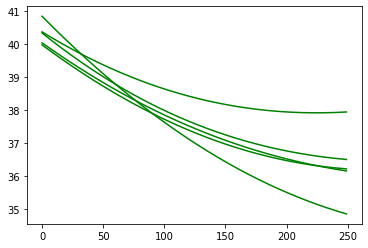

In [129]:
# Five fold linear regression
kfold(pd.DataFrame(df), 5, 0, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.


For i = 0, Train RMSE: 40.48873999466024 Test RMSE: 19.113980408577785
For i = 25, Train RMSE: 35.19959103013756 Test RMSE: 16.51098792641674
For i = 50, Train RMSE: 31.273794503709 Test RMSE: 14.686137192615341
For i = 75, Train RMSE: 28.501429024735632 Test RMSE: 13.518089818956538
For i = 100, Train RMSE: 26.66555019141255 Test RMSE: 12.8686422573535
For i = 125, Train RMSE: 25.549957578971366 Test RMSE: 12.595502792353074
For i = 150, Train RMSE: 24.95550244438478 Test RMSE: 12.57121397531373
For i = 175, Train RMSE: 24.714773819603106 Test RMSE: 12.695586094008865
For i = 200, Train RMSE: 24.698435376882617 Test RMSE: 12.897676913148981
For i = 225, Train RMSE: 24.81331020313067 Test RMSE: 13.131104876801142
w:  [[0.00964171]
 [0.0105536 ]
 [0.00938194]
 [0.01104513]
 [0.01044843]
 [0.00901602]
 [0.00867634]]
optimal w:  [[-1.45260149e+08]
 [ 3.53799757e+03]
 [ 2.49649113e+02]
 [ 1.59609848e+01]
 [-2.28403275e+03]
 [ 1.28474551e+06]
 [ 8.72572635e+05]]
----------------------------

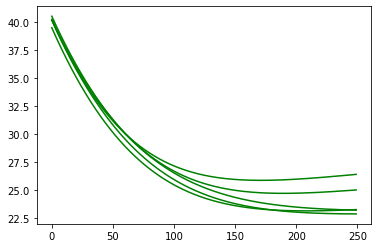

In [115]:
# Five fold linear regression with Lasso regularisation
kfold(pd.DataFrame(df), 5, 0.01, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.


For i = 0, Train RMSE: 40.48873999466024 Test RMSE: 19.113980408577785
For i = 25, Train RMSE: 35.19959103004217 Test RMSE: 16.51098792637095
For i = 50, Train RMSE: 31.273794503422 Test RMSE: 14.686137192487676
For i = 75, Train RMSE: 28.50142902427073 Test RMSE: 13.518089818775552
For i = 100, Train RMSE: 26.665550190859 Test RMSE: 12.868642257186762
For i = 125, Train RMSE: 25.54995757845197 Test RMSE: 12.595502792276942
For i = 150, Train RMSE: 24.95550244401889 Test RMSE: 12.571213975391498
For i = 175, Train RMSE: 24.714773819484403 Test RMSE: 12.695586094282326
For i = 200, Train RMSE: 24.69843537707215 Test RMSE: 12.897676913639465
For i = 225, Train RMSE: 24.813310203659622 Test RMSE: 13.131104877514263
w:  [[0.00964171]
 [0.0105536 ]
 [0.00938194]
 [0.01104513]
 [0.01044843]
 [0.00901602]
 [0.00867634]]
optimal w:  [[-1.45260149e+08]
 [ 3.53799757e+03]
 [ 2.49649113e+02]
 [ 1.59609848e+01]
 [-2.28403275e+03]
 [ 1.28474551e+06]
 [ 8.72572635e+05]]
-----------------------------

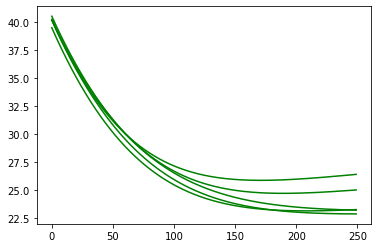

In [116]:
# Five fold linear regression with Ridge regularisation
kfold(pd.DataFrame(df), 5, 0.01, True)